In [ ]:
pip install -e ../../../dea-notebooks/Tools/

In [2]:
cd /gdata1/projects/coastal/intertidal/intertidal_change/

/gdata1/projects/coastal/intertidal/intertidal_change


In [3]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import glob
import datacube
import odc.geo.xr
import xarray as xr
import geopandas as gpd
import pandas as pd
from dea_tools.dask import create_local_dask_cluster
from dea_tools.temporal import xr_regression

dc = datacube.Datacube()
client = create_local_dask_cluster(return_client=True)

aus = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp").query("FEAT_CODE == 'coastline'")


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40437,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:38551,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/45019/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:42087,


## Generate regression outputs

In [8]:
grid_gdf = gpd.read_file("/home/jovyan/Robbi/dea-intertidal/data/raw/ga_summary_grid_c3_32km_coastal.geojson").set_index("region_code")
region_list = grid_gdf.index

In [10]:
outputs = []

for region_code in tqdm.tqdm(region_list):
    
    # if not os.path.exists(f"{region_code}.nc"):

        query_params = dict(
            region_code=region_code,
        )

        load_params = dict(
            measurements=["elevation", "elevation_uncertainty"],
            dask_chunks={},
        )

        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            **query_params,
        )

        if len(dss) > 0:

            ds = dc.load(
                product="ga_s2ls_intertidal_cyear_3",
                datasets=dss,
                **load_params,
            )

            # Mask by certainty
            ds = ds.where(ds.elevation_uncertainty < 0.3)
            ds.load()

            # Calculate regression between elevation values (3D) and time (1D)
            regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)
            
            # Add mean elevation to data
            regression_ds["elevation_mean"] = ds.elevation.mean(dim="time")

            # Export
            regression_ds.to_netcdf(f"{region_code}.nc")
            # for var in regression_ds.data_vars:
            #     regression_ds[var].odc.write_cog(f"{region_code}_{var}.tif", overwrite=True)

  0%|          | 0/3 [00:02<?, ?it/s]


TypeError: 'tuple' object does not support item assignment

In [195]:
regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)

In [197]:
regression_outliers_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year, outliers_y=4.0)

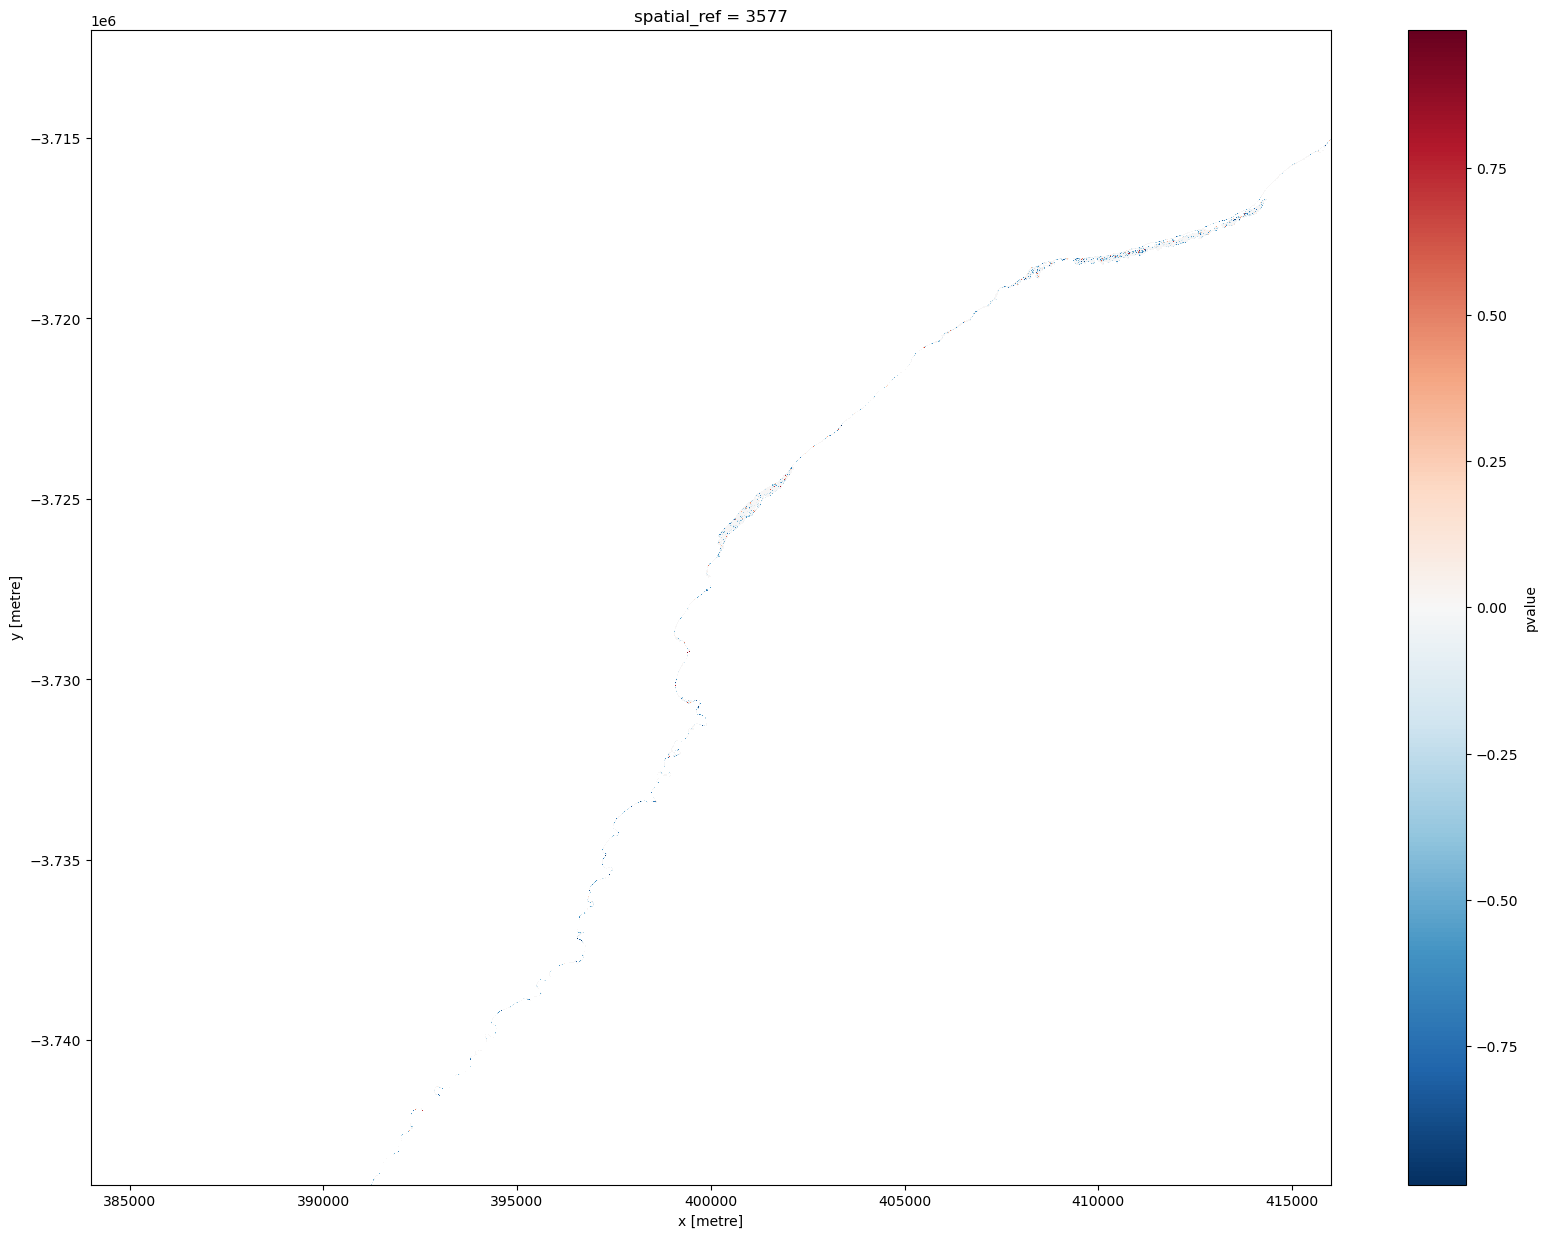

In [200]:
(regression_ds.pvalue - regression_outliers_ds.pvalue).plot.imshow(size=15)

In [184]:
regression_ds.slope.odc.write_cog("slope_nooutliers.tif")

PosixPath('slope_nooutliers.tif')

In [91]:
x_in, y_in = xr_regression(y=ds.elevation, x=ds.time.dt.year)

In [17]:
median = y.median(dim="time")

In [27]:
import numpy as np
diff = ((y - median) ** 2).sum()

In [28]:
diff

<xarray.DataArray 'elevation' ()> Size: 4B
array(234.49278, dtype=float32)
Coordinates:
    spatial_ref  int32 4B 3577

In [153]:
points= np.expand_dims(y_in.isel(y=1588, x=1547).values, axis=1)

# MAD
median = np.median(points, axis=0)
diff = np.sum((points - median) ** 2, axis=-1)
diff = np.sqrt(diff)
# med_abs_deviation = np.median(diff)
# modified_z_score = 0.6745 * diff / med_abs_deviation

diff

array([0.02454746, 0.04089844, 0.0200997 , 0.02327108, 0.00487334,
       0.        , 0.00596204], dtype=float32)

In [152]:
abs_deviation.isel(y=[1588], x=[1547])

<xarray.DataArray 'elevation' (time: 7, y: 1, x: 1)> Size: 28B
array([[[0.02454746]],

       [[0.04089844]],

       [[0.0200997 ]],

       [[0.02327108]],

       [[0.00487334]],

       [[0.        ]],

       [[0.00596204]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 56B 2016-07-01T23:59:59.999999 ... 202...
  * y            (y) float64 8B -3.728e+06
  * x            (x) float64 8B 3.995e+05
    spatial_ref  int32 4B 3577

In [155]:
def mad_outliers(data, dim="time", threshold=3.5):
    """
    Identify outliers along an xarray dimension using Median Absolute
    Deviation (MAD).

    Parameters
    ----------
    data : xarray.DataArray)
        The input data array with dimensions time, x, y.
    threshold : float)
        The number of MADs away from the median to consider a point an 
        outlier.

    Returns
    -------
    xarray.DataArray: 
        A boolean array with the same dimensions as input data, where 
        True indicates an outlier.
    """
    # Calculate the median along the time dimension
    median = data.median(dim=dim)

    # Calculate the absolute deviations from the median
    abs_deviation = np.abs(data - median)

    # Calculate the MAD (median of the absolute deviations)
    mad = abs_deviation.median(dim=dim)

    # Deviations greater than (threshold * MAD) are considered outliers
    outliers = abs_deviation > (threshold * mad)

    return outliers

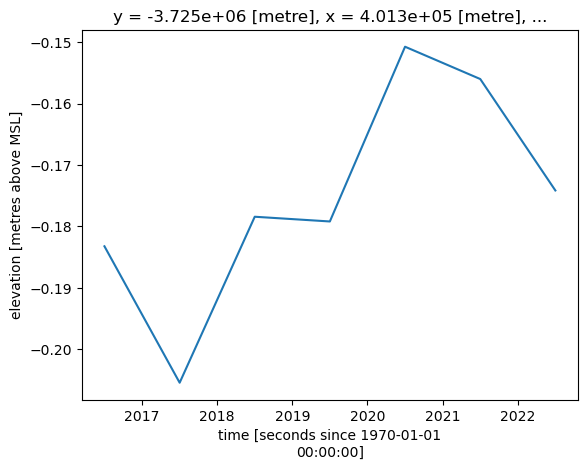

In [169]:
y_in.sel(x=401313.475,y=-3724823.939, method="nearest").plot()

In [187]:
outliers = mad_outliers(y_in, threshold=4)

In [188]:
outliers.sel(x=401313.475,y=-3724823.939, method="nearest")

<xarray.DataArray 'elevation' (time: 7)> Size: 7B
array([False,  True, False, False,  True,  True, False])
Coordinates:
  * time         (time) datetime64[ns] 56B 2016-07-01T23:59:59.999999 ... 202...
    y            float64 8B -3.725e+06
    x            float64 8B 4.013e+05
    spatial_ref  int32 4B 3577

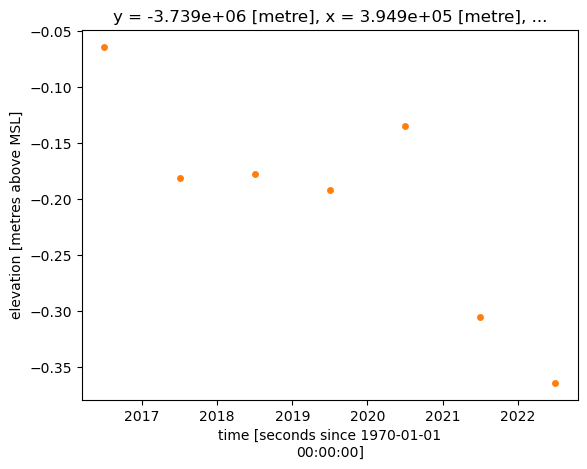

In [189]:
x_coord, y_coord = 394944.107,-3738964.292

y_in.where(outliers).sel(x=x_coord,y=y_coord, method="nearest").plot.scatter()
y_in.where(~outliers).sel(x=x_coord,y=y_coord, method="nearest").plot.scatter()

In [194]:
item = 3.6



3.6

(array([1.2849e+04, 4.2863e+04, 4.9801e+04, 2.0071e+04, 8.7040e+03,
        6.4420e+03, 6.3910e+03, 1.7240e+03, 3.9200e+02, 4.6000e+01]),
 array([-0.72277188, -0.61971533, -0.51665878, -0.41360223, -0.31054568,
        -0.20748912, -0.10443257, -0.00137601,  0.10168054,  0.2047371 ,
         0.30779365]),
 <BarContainer object of 10 artists>)

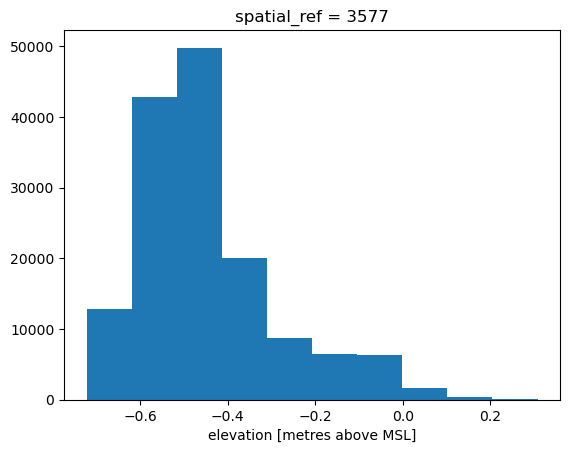

In [166]:
y_in.where(~outliers).plot.hist()

In [149]:
# Calculate the median along the time dimension
median = y.median(dim='time')

# Calculate the absolute deviations from the median
abs_deviation = np.abs(y - median)

# Calculate the MAD (median of the absolute deviations)
mad = abs_deviation.median(dim='time')

mad  #.isel(y=[1588], x=[1547])

# Identify outliers: deviations greater than (threshold * MAD) are considered outliers
# outliers = abs_deviation > (threshold * mad)


<xarray.DataArray 'elevation' (y: 3200, x: 3200)> Size: 41MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 26kB -3.712e+06 -3.712e+06 ... -3.744e+06
  * x            (x) float64 26kB 3.84e+05 3.84e+05 ... 4.16e+05 4.16e+05
    spatial_ref  int32 4B 3577

In [146]:
y = y_in  #.isel(y=[1588], x=[1547])

median = y.median(dim="time")
diff = ((y - median) ** 2)
# diff = np.sqrt(diff)
# med_abs_deviation = diff.median(dim="time")
# modified_z_score = 0.6745 * diff / med_abs_deviation

diff.isel(y=[1588], x=[1547])

<xarray.DataArray 'elevation' (time: 7, y: 1, x: 1)> Size: 28B
array([[[6.0257770e-04]],

       [[1.6726826e-03]],

       [[4.0399792e-04]],

       [[5.4154336e-04]],

       [[2.3749397e-05]],

       [[0.0000000e+00]],

       [[3.5545967e-05]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 56B 2016-07-01T23:59:59.999999 ... 202...
  * y            (y) float64 8B -3.728e+06
  * x            (x) float64 8B 3.995e+05
    spatial_ref  int32 4B 3577

In [138]:
((y - median) ** 2).sum(time=

<xarray.DataArray 'elevation' (time: 7, y: 3200, x: 3200)> Size: 287MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 56B 2016-07-01T23:59:59.999999 ... 202...
  * y            (y) float64 26kB -3.712e+06 -3.712e+06 ... -3.744e+06
  * x            (x) float64 26kB 3.84e+05 3.84e+05 ... 4.16e+05 4.16e+05
    spatial_ref  int32 4B 3577

array([0.15667628, 0.20223363, 0.1417734 , 0.15254863, 0.06980928,
       0.        , 0.07721427], dtype=float32)

<xarray.DataArray 'elevation' (time: 7)> Size: 28B
array([6.0257770e-04, 1.6726826e-03, 4.0399792e-04, 5.4154336e-04,
       2.3749397e-05, 0.0000000e+00, 3.5545967e-05], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 56B 2016-07-01T23:59:59.999999 ... 202...
    spatial_ref  int32 4B 3577

In [80]:
modified_z_score

array([0.8237566 , 1.3724582 , 0.6745    , 0.7809244 , 0.163538  ,
       0.        , 0.20007259], dtype=float32)

In [61]:
points - median

array([-0.02454746,  0.04089844,  0.0200997 ,  0.02327108, -0.00487334,
        0.        , -0.00596204], dtype=float32)

In [ ]:
for region_code in tqdm.tqdm(region_list):
    
    if os.path.exists(f"{region_code}.nc"):

        query_params = dict(
            region_code=region_code,
        )

        load_params = dict(
            measurements=["elevation", "elevation_uncertainty"],
            dask_chunks={},
        )

        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            **query_params,
        )

        if len(dss) > 0:

            ds = dc.load(
                product="ga_s2ls_intertidal_cyear_3",
                datasets=dss,
                **load_params,
            )

            # Mask by certainty
            ds = ds.where(ds.elevation_uncertainty < 0.3)
            ds.load()
            
            # Load regression data
            regression_ds = xr.open_dataset(
                f"{region_code}.nc",
            )

            # Add mean elevation to dataset
            regression_ds["elevation_mean"] = ds.elevation.mean(dim="time")
            regression_ds.to_netcdf(f"../intertidal_change2/{region_code}.nc")

### Convert NetCDF to COG

In [ ]:
band = "pvalue"

for region_code in tqdm.tqdm(region_list): 
    
    if not os.path.exists(f"{region_code}_{band}.tif"):
    
        try:
            regression_ds = xr.open_dataset(
                f"{region_code}.nc", 
                drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
            )
            regression_ds[band].odc.write_cog(f"{region_code}_{band}.tif", overwrite=True)
        except:
            pass

In [ ]:
# import rioxarray

# slope = rioxarray.open_rasterio("regression_slope.tif", chunks={"x": 8192, "y": 8192})
# pvalue = rioxarray.open_rasterio("regression_pvalue.tif", chunks={"x": 8192, "y": 8192})
# slope_masked = slope.where(pvalue < 0.05)

### Merge into continental layers

In [ ]:
# Set file path names
file_list_name = f"regression_{band}.txt"
vrt_name = f"regression_{band}.vrt"
output_name = f"regression_{band}.tif"
nodata = "nan"

if not os.path.exists(vrt_name):
    
    pd.Series(glob.glob(f"*_{band}.tif")).to_csv(file_list_name, index=False, header=False)

    # Use text file of file paths to create VRT
    os.system(
        f"gdalbuildvrt {vrt_name} -input_file_list {file_list_name} -vrtnodata {nodata}"
    )

# Convert VRT to COG GeoTIFF with compression
os.system(
    f"gdal_translate {vrt_name} {output_name} -co NUM_THREADS=ALL_CPUS -of COG -co BIGTIFF=YES -co COMPRESS=DEFLATE -co LEVEL=9 -co PREDICTOR=YES -co BLOCKSIZE=1024"
)

In [ ]:
!gdalinfo regression_slope.tif

## Load data and calculate stats

In [ ]:
outputs_change = []
outputs_perc = []

for region_code in tqdm.tqdm(region_list):    
    
    try:
        regression_ds = xr.open_dataset(
            f"{region_code}.nc", 
            drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
        )

        test_data = (
            regression_ds[["slope"]]
            .where(regression_ds.pvalue < 0.05, 0)
            .where(regression_ds.slope.notnull)
        )

        test_data["lower"] = test_data.slope.where(regression_ds.elevation_mean < 0)
        test_data["upper"] = test_data.slope.where(regression_ds.elevation_mean > 0)
        test_data = test_data.rename({"slope": "all"})

        a = ((test_data < -0.1)).sum().assign_coords(category="< -0.1 m")
        b = ((test_data >= -0.1) & (test_data < -0.05)).sum().assign_coords(category="-0.05 to -0.10 m")
        c = ((test_data >= -0.05) & (test_data < -0.03)).sum().assign_coords(category="-0.03 to -0.05 m")
        d = ((test_data >= -0.03) & (test_data <= 0.03)).sum().assign_coords(category="Non-significant")
        e = ((test_data > 0.03) & (test_data <= 0.05)).sum().assign_coords(category="0.03 to 0.05 m")
        f = ((test_data > 0.05) & (test_data <= 0.10)).sum().assign_coords(category="0.05 to 0.10 m")
        g = ((test_data > 0.1)).sum().assign_coords(category="> 0.1 m")

        change_df = (xr.concat([a, b, c, d, e, f, g], dim="category")
                     .to_dataframe()
                     .drop("spatial_ref", axis=1))
        change_perc_df = (change_df * 100 / change_df.sum())
        outputs_change.append(change_df.T.assign(region=region_code))
        outputs_perc.append(change_perc_df.T.assign(region=region_code))
    except:
        pass
    
    

In [ ]:
# regression_ds = xr.open_dataset(
#             "x106y154.nc", 
#             drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
# )

In [ ]:
# regression_ds.slope.odc.explore(vmin=-0.05, vmax=0.05, cmap="RdBu")

In [ ]:
combined_results_n = pd.merge(
    grid_gdf,
    pd.concat(outputs_change).loc["lower"].rename_axis("region_code"),
    left_index=True,
    right_index=True,
)

combined_results_perc = pd.merge(
    grid_gdf,
    pd.concat(outputs_perc).loc["lower"].set_index("region"),
    left_index=True,
    right_index=True,
)

combined_results_perc["all_loss"] = combined_results_perc.loc[:, ["< -0.1 m", "-0.05 to -0.10 m", "-0.03 to -0.05 m"]].sum(axis=1)
combined_results_perc["all_gain"] = combined_results_perc.loc[:, ["> 0.1 m", "0.05 to 0.10 m", "0.03 to 0.05 m"]].sum(axis=1)
combined_results_perc["dynamic"] = 100 - combined_results_perc["Non-significant"]
combined_results_perc["n"] = combined_results_n.iloc[:, 4:].sum(axis=1)
combined_results_perc
# combined_results_perc = combined_results_perc.query("n > 5000")

In [ ]:
pd.merge(
    grid_gdf,
    pd.concat(outputs_perc).loc["lower"].rename_axis("region_code"),
    left_index=True,
    right_index=True,
)

In [ ]:
((combined_results_perc.iloc[:, 4:].sum(axis=0) * 100) / combined_results_perc.iloc[:, 4:].sum().sum()).round(2)  # upper

In [ ]:
((combined_results_perc.iloc[:, 4:].sum(axis=0) * 100) / combined_results_perc.iloc[:, 4:].sum().sum()).round(2)  # lower

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
combined_results_perc.query("dynamic >= 0").plot(edgecolor="black", linewidth=1, ax=ax[0], zorder=0)
combined_results_perc.query("all_loss >= 0").plot(edgecolor="black", linewidth=1, ax=ax[1], zorder=0)
combined_results_perc.query("all_gain >= 0").plot(edgecolor="black", linewidth=1, ax=ax[2], zorder=0)
combined_results_perc.plot(column="dynamic", vmin=0, vmax=20, legend=True, ax=ax[0], legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_loss", vmin=0, vmax=20, ax=ax[1], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_gain", vmin=0, vmax=20, ax=ax[2], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
ax[0].set_title("Percent dynamic (loss or gain)")
ax[1].set_title("Percent with loss trend")
ax[2].set_title("Percent with gain trend")

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
combined_results_perc.query("dynamic >= 0").plot(edgecolor="black", linewidth=1, ax=ax[0], zorder=0)
combined_results_perc.query("all_loss >= 0").plot(edgecolor="black", linewidth=1, ax=ax[1], zorder=0)
combined_results_perc.query("all_gain >= 0").plot(edgecolor="black", linewidth=1, ax=ax[2], zorder=0)
combined_results_perc.plot(column="dynamic", vmin=0, vmax=20, legend=True, ax=ax[0], legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_loss", vmin=0, vmax=20, ax=ax[1], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_gain", vmin=0, vmax=20, ax=ax[2], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
ax[0].set_title("Percent dynamic (loss or gain)")
ax[1].set_title("Percent with loss trend")
ax[2].set_title("Percent with gain trend")

In [ ]:
combined_results

In [ ]:
combined_results = pd.merge(
    grid_gdf,
    pd.concat(outputs_change).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
combined_results["all_loss"] = combined_results.loc[:, ["< -0.1 m", "-0.05 to -0.10 m", "-0.03 to -0.05 m"]].sum(axis=1)
combined_results["all_gain"] = combined_results.loc[:, ["> 0.1 m", "0.05 to 0.10 m", "0.03 to 0.05 m"]].sum(axis=1)
combined_results["dynamic"] = 100 - combined_results["Non-significant"]

In [ ]:
combined_results.plot(column="Non-significant", vmax=500000)

## Coastal compartments

In [ ]:
compartments_gdf = gpd.read_file("/gdata1/data/beach_slopes/primary_compartments.geojson").set_index("primary_comp_id")

In [ ]:
from odc.geo.geom import Geometry

region_list = compartments_gdf.index
region_code = "NSW02.02"


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tqdm

outputs = []

region_list = ["SA02.02"]

for region_code in tqdm.tqdm(region_list):

    geom = Geometry(compartments_gdf.loc[region_code].geometry, crs="EPSG:4326")

    query_params = dict(
        geopolygon=geom,
    )

    load_params = dict(
        measurements=["elevation", "elevation_uncertainty"],
        dask_chunks={"x": 4096, "y": 4096},
    )

    dss = dc.find_datasets(
        product="ga_s2ls_intertidal_cyear_3",
        **query_params,
    )

    if len(dss) > 0:

        ds = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            datasets=dss,
            **load_params,
        )

        # Mask by polygon extent
        ds = ds.odc.mask(geom)

        # Mask by certainty
        ds = ds.where(ds.elevation_uncertainty < 0.3)
        ds.load()

        # Stack
        ds_stacked = ds.stack(z=["y", "x"]).dropna(dim="z", how="all")

        # Calculate regression between elevation values (3D) and time (1D)
        regression_ds = xr_regression(y=ds_stacked.elevation, x=ds_stacked.time.dt.year)

        # Identify significant changes only
        sig_change = regression_ds.slope.where(regression_ds.pvalue < 0.05)

        # Mean elevation
        mean_elevation = ds_stacked.elevation.mean(dim="time")

        # Compute summary stats
        summary_df_all = (
            sig_change.to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="all")
        )

        # Compute summary stats
        summary_df_upper = (
            sig_change.where(mean_elevation > 0)
            .to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="upper")
        )

        # Compute summary stats
        summary_df_lower = (
            sig_change.where(mean_elevation < 0)
            .to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="lower")
        )

        outputs.append(summary_df_all)
        outputs.append(summary_df_upper)
        outputs.append(summary_df_lower)


In [ ]:
test_data = (
    regression_ds[["slope"]]
    .where(regression_ds.pvalue < 0.05, 0)
)

test_data["lower"] = test_data.slope.where(mean_elevation < 0)
test_data["upper"] = test_data.slope.where(mean_elevation > 0)
test_data = test_data.rename({"slope": "all"})

a = ((test_data < -0.1)).sum().assign_coords(category="< -0.1 m")
b = ((test_data >= -0.1) & (test_data < -0.05)).sum().assign_coords(category="-0.05 to -0.10 m")
c = ((test_data >= -0.05) & (test_data < -0.03)).sum().assign_coords(category="-0.03 to -0.05 m")
d = ((test_data >= -0.03) & (test_data <= 0.03)).sum().assign_coords(category="Non-significant")
e = ((test_data > 0.03) & (test_data <= 0.05)).sum().assign_coords(category="0.03 to 0.05 m")
f = ((test_data > 0.05) & (test_data <= 0.10)).sum().assign_coords(category="0.05 to 0.10 m")
g = ((test_data > 0.1)).sum().assign_coords(category="> 0.1 m")

In [ ]:
change_df = xr.concat([a, b, c, d, e, f, g], dim="category").to_dataframe().drop("spatial_ref", axis=1)
change_perc_df = (change_df * 100 / change_df.sum())

In [ ]:
change_df.round(2)

In [ ]:
change_perc_df.round(2)

In [ ]:
test = regression_ds.slope.where(mean_elevation < 0)
test.plot.hist(bins=200, xlim=(-0.25, 0.25))
plt.gca().axvline(test.median(), color="red");

In [ ]:
test = regression_ds.slope.where(mean_elevation > 0)
test.plot.hist(bins=200, xlim=(-0.25, 0.25))
plt.gca().axvline(test.median(), color="red");

In [ ]:
combined_results = pd.merge(
    compartments_gdf,
    pd.concat(outputs).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
# combined_results["geometry"] = combined_results["geometry"].centroid
combined_results["total"] = combined_results["mean"] * 7

In [ ]:
# ax = aus.plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'lower')").sort_values(by="50%", key=abs).plot(
    column="50%",
    cmap="RdBu",
    vmin=-0.05,
    vmax=0.05,
    # vmin=-0.5,
    # vmax=0.5,
    # ax=ax,
    zorder=1,
    figsize=(10, 6),
    # s=15,
    linewidth=0.2,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
# pd.concat(outputs).rename_axis("region_code").to_csv("intertidal_summary_stats_secondary.csv")

In [ ]:
# # combined_results[["50%", "geometry", "classification"]].pivot(columns=["classification"], values=["50%"], index="geometry").reset_index()



# pd.merge(
#     compartments_gdf,
#     pd.concat(outputs).rename_axis("region_code").pivot(columns=["classification"], values=["50%"]),
#     left_index=True,
#     right_index=True)

In [ ]:
test = pd.merge(
    compartments_gdf,
    pd.concat(outputs).rename_axis("region_code").pivot(columns=["classification"], values=["50%"]).droplevel(level=0, axis=1),
    left_index=True,
    right_index=True)

In [ ]:
test["test"] = test.upper - test.lower

In [ ]:
test.plot(column="upper", legend=True, cmap="RdBu", vmin=-0.05, vmax=0.05)

In [ ]:
test.plot(column="lower", legend=True, cmap="RdBu", vmin=-0.05, vmax=0.05)

In [ ]:
compartments_gdf.index.nlevels

In [ ]:
test.index.nlevels

## Specific tiles

In [ ]:
grid_gdf = gpd.read_file("../../data/raw/ga_summary_grid_c3_32km_coastal.geojson").set_index("region_code")

In [ ]:
region_list = grid_gdf.index

In [ ]:
# region_list = ['x149y166', 'x149y167', 'x150y165', 'x150y166', 'x150y167', 'x151y164', 'x151y165', 'x151y167', 'x152y163', 'x152y164', 'x153y162', 'x153y163', 'x153y164', 'x154y162', 'x154y163', 'x154y164', 'x155y162', 'x155y163', 'x156y161', 'x156y162', 'x157y160', 'x157y161', 'x158y159', 'x158y160', 'x159y159', 'x160y159', 'x161y157', 'x161y158', 'x161y159', 'x161y160', 'x162y157', 'x162y158', 'x162y159', 'x162y160', 'x162y161', 'x163y156', 'x163y157', 'x163y158', 'x163y159', 'x163y160', 'x164y156', 'x164y159', 'x164y160', 'x165y156', 'x166y156', 'x167y156', 'x167y157', 'x167y158', 'x168y158', 'x168y159', 'x169y159', 'x169y160', 'x169y161', 'x169y162', 'x169y163']

In [ ]:
import tqdm

outputs = []

for region_code in tqdm.tqdm(region_list):

    query_params = dict(
        region_code=region_code,
    )

    load_params = dict(
        measurements=["elevation", "elevation_uncertainty"],
        dask_chunks={"x": 1600, "y": 1600},
        # dask_chunks={},
    )

    dss = dc.find_datasets(
        product="ga_s2ls_intertidal_cyear_3",
        **query_params,
    )

    if len(dss) > 0:

        ds = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            datasets=dss,
            **load_params,
        )

        # Mask by certainty
        ds = ds.where(ds.elevation_uncertainty < 0.3)
        ds.load()

        # Calculate regression between elevation values (3D) and time (1D)
        regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)
        # regression_ds.load()

        # Identify significant changes only
        sig_change = regression_ds.slope.where(regression_ds.pvalue < 0.05)

        # Compute summary stats
        summary_df_all = (
            sig_change.drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="all")
        )
        
        # Compute summary stats
        summary_df_upper = (
            sig_change.where(ds.elevation > 0).drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="upper")
        )
        
        # Compute summary stats
        summary_df_lower = (
            sig_change.where(ds.elevation < 0).drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="lower")
        )

        outputs.append(summary_df_all)
        outputs.append(summary_df_upper)
        outputs.append(summary_df_lower)

In [ ]:
aus = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp")

combined_results = pd.merge(
    grid_gdf,
    pd.concat(outputs).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
combined_results["geometry"] = combined_results["geometry"].centroid
combined_results["total"] = combined_results["mean"] * 7

In [ ]:
pd.concat(outputs).rename_axis("region_code").to_csv("intertidal_summary_stats.csv")

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'upper') & (count > 5000)").sort_values(by="mean", key=abs).plot(
    column="mean",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.5,
    # vmax=0.5,
    ax=ax,
    zorder=1,
    s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'lower') & (count > 5000)").sort_values(by="mean", key=abs).plot(
    column="mean",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.5,
    # vmax=0.5,
    ax=ax,
    zorder=1,
    s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5, alpha=0, figsize=(10, 10))
combined_subset = combined_results.query("(classification == 'upper') & (count > 1000)").sort_values(by="50%", key=abs)
combined_subset.plot(
    column="50%",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.3,
    # vmax=0.3,
    # edgecolor="black",
    # linewidth=0.1,
    ax=ax,
    zorder=2,
    # s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
    markersize=(combined_subset['count'] ** 0.5) / 25 + 5
)
combined_subset.plot(
    c="black",
    markersize=(combined_subset['count'] ** 0.5) / 25 + 10,
    ax=ax,
    zorder=1
)

In [ ]:
(combined_subset['count'] ** 0.5) / 100

In [ ]:
import matplotlib.pyplot as plt
from dea_tools.temporal import xr_regression

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(regression_ds.data_vars):
    print(f"Plotting {var}")
    regression_ds[var].drop("spatial_ref").plot.imshow(ax=axes[i], add_labels=False, robust=True)
    axes[i].set_title(var)

In [ ]:
sig_change = regression_ds.where(regression_ds.pvalue < 0.05)

In [ ]:
sig_change.slope.drop_vars("spatial_ref").plot.hist(bins=50);

In [ ]:
regression_ds.where(regression_ds.pvalue < 0.05).slope.plot.imshow(size=10, vmin=-0.1, vmax=0.1, cmap="RdBu")

In [ ]:
regression_ds.slope.odc.write_cog("intertidal_change.tif")

In [ ]:
regression_ds.pvalue.odc.write_cog("intertidal_change_pvalue.tif")

In [ ]:
regression_ds.slope.where(regression_ds.pvalue < 0.05).odc.write_cog("intertidal_change_sig.tif")

In [ ]:

import seaborn as sns

# sns.ecdfplot(data=ds.elevation.isel(time=0).stack(z=["x", "y"]))

In [ ]:
# testing = 

data = ds.elevation.stack(z=["x", "y"]).to_dataframe().reset_index(level=["x", "y"], drop=True).dropna(subset="elevation", how='all')


# sns.ecdfplot(data=data[["elevation"]], hue="time")

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
out = xr_regression(y=ds.elevation, x=ds.time.dt.year)

In [ ]:
# lag_linregress_3D(y=ds.elevation.isel(x=260, y=260), x=ds.time.dt.year)

In [ ]:
# from scipy import stats
# 
# stats.linregress(x=ds.time.dt.year, y=ds.elevation.isel(x=260, y=260))

In [ ]:
# test = ds[["elevation"]].polyfit(dim="time", deg=0)

In [ ]:
# test.elevation_polyfit_coefficients.plot(col="degree", robust=True)